In [80]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.manifold import TSNE 
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from seaborn import countplot,lineplot, barplot
le = preprocessing.LabelEncoder()
from sklearn.preprocessing import LabelEncoder


In [81]:
# Load the datasets
train_df = pd.read_csv('../input/X_train.csv')
y_train = pd.read_csv('../input/y_train.csv')
test_df = pd.read_csv('../input/X_test.csv')

In [82]:
train_df.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [83]:
test_df.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000,488448.000000
mean,1907.500000,63.500000,0.031996,0.120651,0.018735,0.004024,0.000401,0.013669,-0.036101,0.125433,2.906588,-9.359811
std,1101.585403,36.949327,0.671977,0.714522,0.108481,0.100957,0.114485,0.089440,0.233791,1.832639,2.094727,2.802670
min,0.000000,0.000000,-0.989720,-0.989810,-0.154680,-0.156270,-2.403300,-1.193000,-1.458200,-35.040000,-107.480000,-83.173000
25%,953.750000,31.750000,-0.648130,-0.744503,-0.112660,-0.098435,-0.037396,-0.029865,-0.089842,-0.486233,2.052100,-10.125000
50%,1907.500000,63.500000,0.132910,0.397860,0.057271,0.022654,0.001107,0.007276,-0.008911,0.112490,2.900300,-9.361700
75%,2861.250000,95.250000,0.575270,0.803600,0.124770,0.083706,0.037827,0.051112,0.057876,0.727250,3.758000,-8.582075
max,3815.000000,127.000000,0.989320,0.988940,0.154250,0.152510,3.396600,1.150700,0.960280,36.628000,55.624000,59.633000


In [84]:
y_train.describe()

,series_id,group_id
count,3810.000000,3810.000000
mean,1904.500000,37.601312
std,1099.996591,20.982743
min,0.000000,0.000000
25%,952.250000,19.000000
50%,1904.500000,39.000000
75%,2856.750000,55.000000
max,3809.000000,72.000000


In [85]:
# Check for missing values
print(train_df.isnull().sum())
print(test_df.isnull().sum())
print(y_train.isnull().sum())

row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64
row_id                   0
series_id                0
measurement_number       0
orientation_X            0
orientation_Y            0
orientation_Z            0
orientation_W            0
angular_velocity_X       0
angular_velocity_Y       0
angular_velocity_Z       0
linear_acceleration_X    0
linear_acceleration_Y    0
linear_acceleration_Z    0
dtype: int64
series_id    0
group_id     0
surface      0
dtype: int64


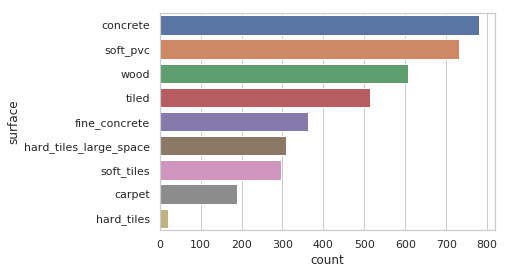

In [86]:
# Count of target classes 
sns.set(style='whitegrid')
sns.countplot(y = 'surface',
              data = y_train,
              order = y_train['surface'].value_counts().index)
plt.show()

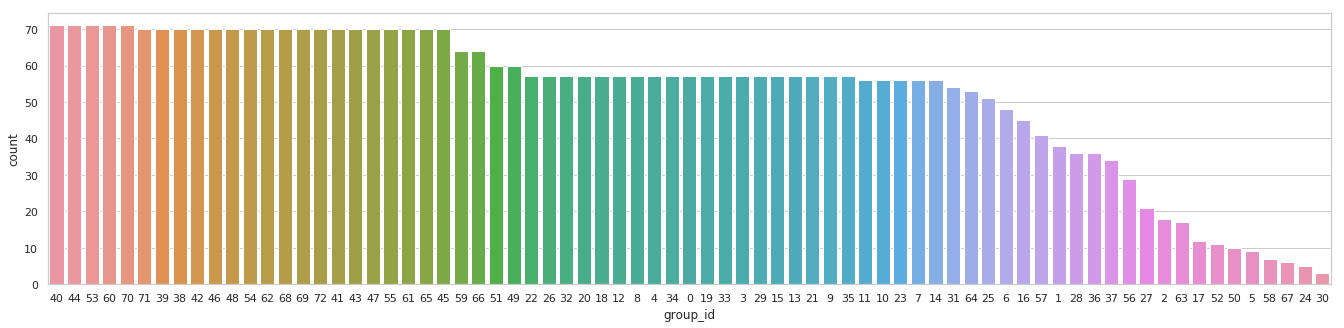

In [87]:
# Count of classes based on group id 
plt.figure(figsize=(23,5)) 
sns.despine()
countplot(x="group_id", data=y_train, order = y_train['group_id'].value_counts().index)
plt.show()

In [88]:
series1 = train_df.head(128)
series1.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


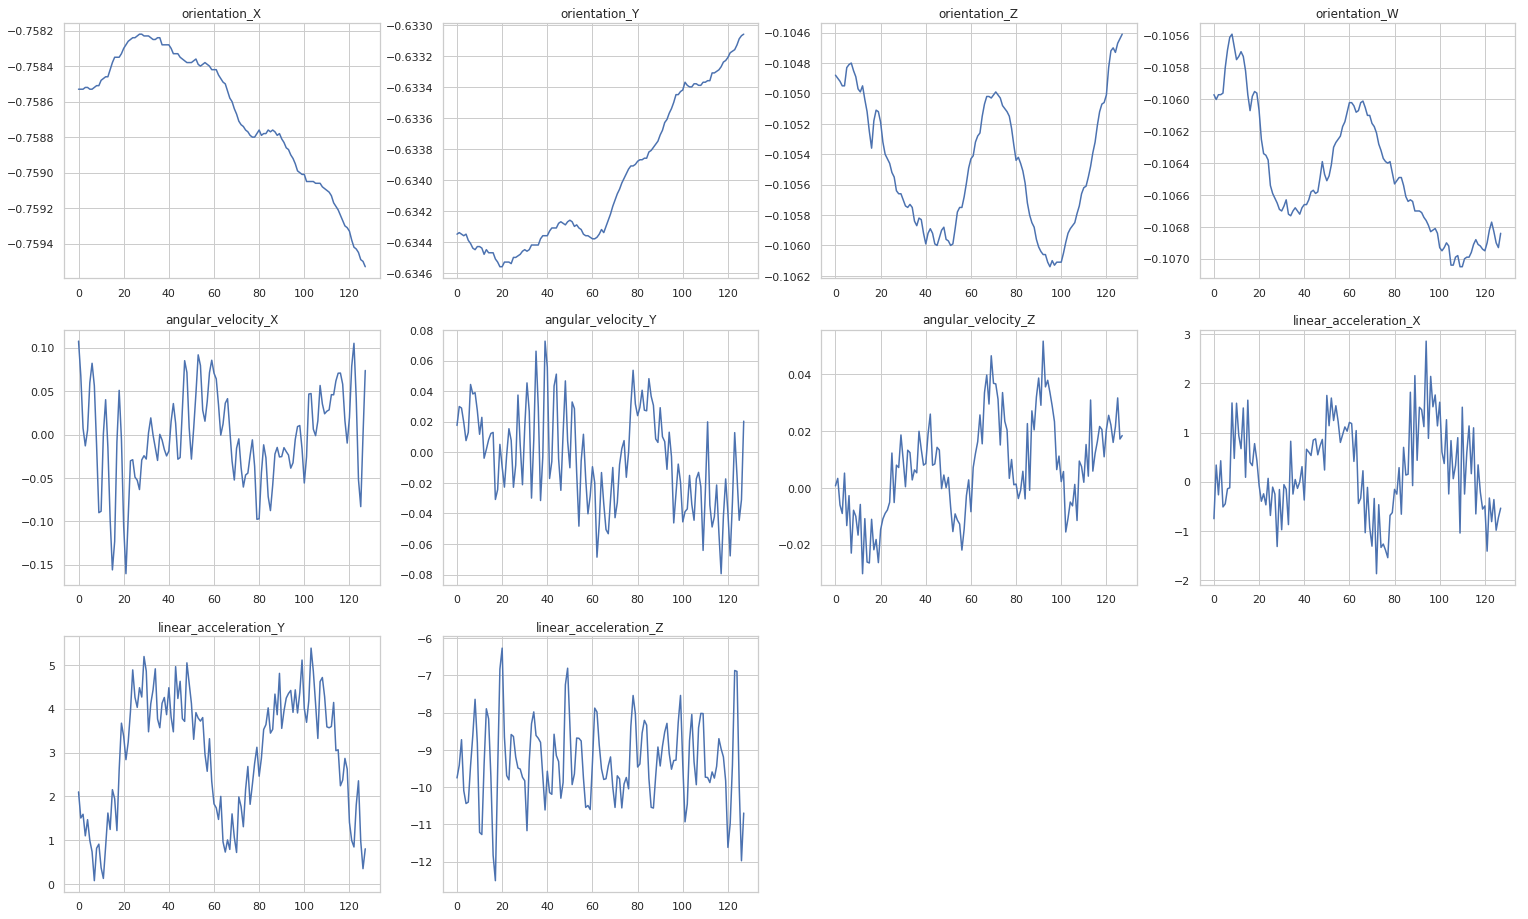

In [89]:
# Plots of series 1
plt.figure(figsize=(26, 16))
for i, col in enumerate(series1.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.plot(series1[col])
    plt.title(col)

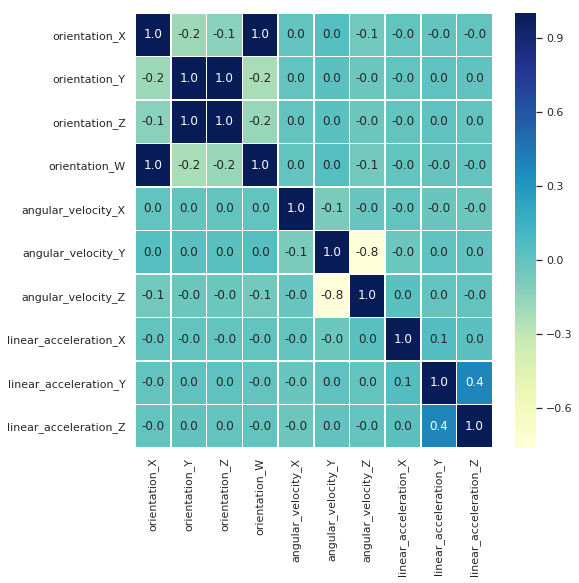

In [90]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(train_df.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap="YlGnBu")

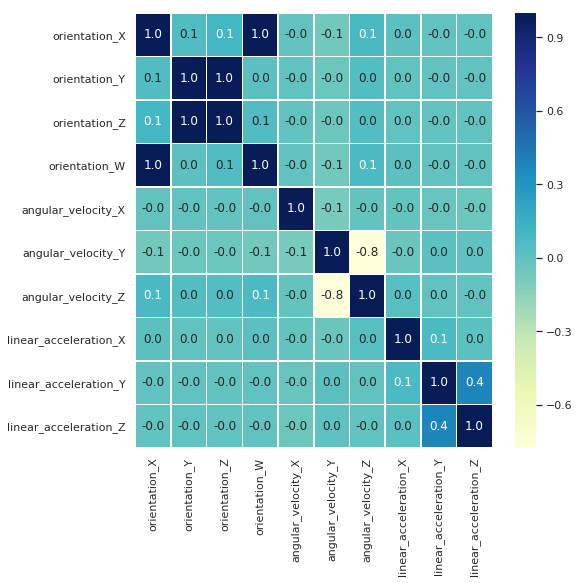

In [91]:
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(test_df.iloc[:,3:].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax, cmap="YlGnBu")

In [92]:
def plot_feature_distribution(classes,target, features,a=5,b=2):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(a,b,figsize=(16,24))

    for f in features:
        i += 1
        plt.subplot(a,b,i)
        for c in classes:
            ttc = target[target['surface']==c]
            sns.kdeplot(ttc[f], bw=0.5,label=c)
        plt.xlabel(f, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show();

<Figure size 432x288 with 0 Axes>

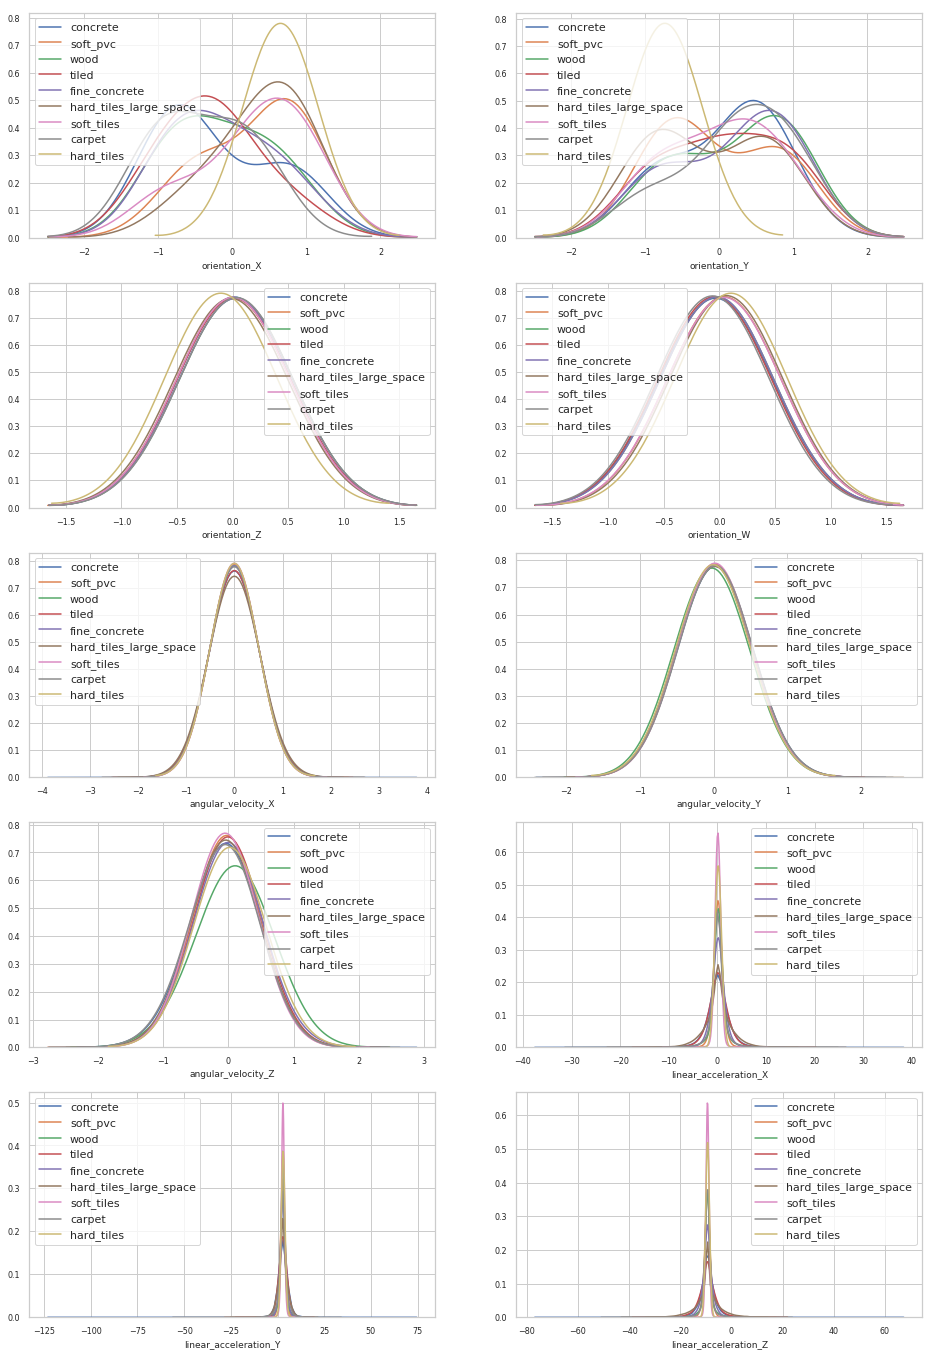

In [93]:
classes = (y_train['surface'].value_counts()).index
target = train_df.merge(y_train, on='series_id', how='inner')
features = train_df.columns.values[3:]
plot_feature_distribution(classes, target, features)

In [94]:
# Conversion of quaternion to Euler angles
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [95]:
def fe_step0 (actual):
    actual['norm_quat'] = (actual['orientation_X']**2 + actual['orientation_Y']**2 + actual['orientation_Z']**2 + actual['orientation_W']**2)
    actual['mod_quat'] = (actual['norm_quat'])**0.5
    actual['norm_X'] = actual['orientation_X'] / actual['mod_quat']
    actual['norm_Y'] = actual['orientation_Y'] / actual['mod_quat']
    actual['norm_Z'] = actual['orientation_Z'] / actual['mod_quat']
    actual['norm_W'] = actual['orientation_W'] / actual['mod_quat']
    
    return actual

In [96]:
train_df = fe_step0(train_df)
test_df = fe_step0(test_df)
train_df.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596


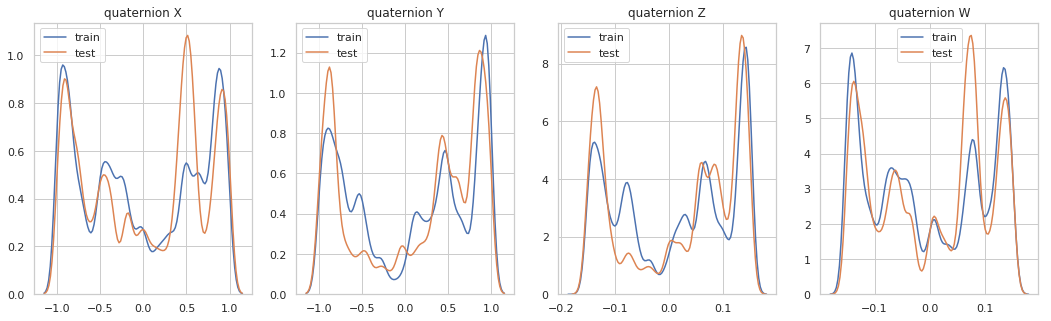

In [97]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(18, 5))

ax1.set_title('quaternion X')
sns.kdeplot(train_df['norm_X'], ax=ax1, label="train")
sns.kdeplot(test_df['norm_X'], ax=ax1, label="test")

ax2.set_title('quaternion Y')
sns.kdeplot(train_df['norm_Y'], ax=ax2, label="train")
sns.kdeplot(test_df['norm_Y'], ax=ax2, label="test")

ax3.set_title('quaternion Z')
sns.kdeplot(train_df['norm_Z'], ax=ax3, label="train")
sns.kdeplot(test_df['norm_Z'], ax=ax3, label="test")

ax4.set_title('quaternion W')
sns.kdeplot(train_df['norm_W'], ax=ax4, label="train")
sns.kdeplot(test_df['norm_W'], ax=ax4, label="test")

plt.show()

In [98]:
# Quaternions to Euler Angles
def fe_step1 (actual):    
    x, y, z, w = actual['norm_X'].tolist(), actual['norm_Y'].tolist(), actual['norm_Z'].tolist(), actual['norm_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    return actual


In [99]:
train_df = fe_step1(train_df)
test_df = fe_step1(test_df)
train_df.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,norm_quat,mod_quat,norm_X,norm_Y,norm_Z,norm_W,euler_x,euler_y,euler_z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,0.999997,0.999999,-0.758531,-0.634351,-0.10488,-0.10597,2.843273,-0.024668,1.396667
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,0.999995,0.999998,-0.758532,-0.634342,-0.10490,-0.10600,2.843201,-0.024662,1.396651
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,1.000006,1.000003,-0.758528,-0.634348,-0.10492,-0.10597,2.843222,-0.024728,1.396677
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,1.000009,1.000005,-0.758516,-0.634357,-0.10495,-0.10597,2.843183,-0.024769,1.396712
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,0.999995,0.999997,-0.758522,-0.634352,-0.10495,-0.10596,2.843197,-0.024785,1.396698


In [100]:
# Feature engineering
def feat_eng(data):
    
    df = pd.DataFrame()
    data['totl_anglr_vel'] = (data['angular_velocity_X']**2 + data['angular_velocity_Y']**2 + data['angular_velocity_Z']**2)** 0.5
    data['totl_linr_acc'] = (data['linear_acceleration_X']**2 + data['linear_acceleration_Y']**2 + data['linear_acceleration_Z']**2)**0.5
    data['totl_xyz'] = (data['orientation_X']**2 + data['orientation_Y']**2 + data['orientation_Z']**2)**0.5
    data['acc_vs_vel'] = data['totl_linr_acc'] / data['totl_anglr_vel']
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    for col in data.columns:
        if col in ['row_id','series_id','measurement_number']:
            continue
        df[col + '_mean'] = data.groupby(['series_id'])[col].mean()
        df[col + '_median'] = data.groupby(['series_id'])[col].median()
        df[col + '_max'] = data.groupby(['series_id'])[col].max()
        df[col + '_min'] = data.groupby(['series_id'])[col].min()
        df[col + '_std'] = data.groupby(['series_id'])[col].std()
        df[col + '_range'] = df[col + '_max'] - df[col + '_min']
        df[col + '_maxtoMin'] = df[col + '_max'] / df[col + '_min']
        df[col + '_mean_abs_chg'] = data.groupby(['series_id'])[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        df[col + '_mean_change_of_abs_change'] = data.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df[col + '_abs_max'] = data.groupby(['series_id'])[col].apply(lambda x: np.max(np.abs(x)))
        df[col + '_abs_min'] = data.groupby(['series_id'])[col].apply(lambda x: np.min(np.abs(x)))
        df[col + '_abs_avg'] = (df[col + '_abs_min'] + df[col + '_abs_max'])/2
    return df

In [101]:
train_df = feat_eng(train_df)
test_df = feat_eng(test_df)

In [102]:
# Fill the missing values
train_df.fillna(0,inplace=True)
test_df.fillna(0,inplace=True)
train_df.replace(-np.inf,0,inplace=True)
train_df.replace(np.inf,0,inplace=True)
test_df.replace(-np.inf,0,inplace=True)
test_df.replace(np.inf,0,inplace=True)

In [103]:
# Label encoding
y_train['surface'] = le.fit_transform(y_train['surface'])

In [104]:
y_train

,series_id,group_id,surface
0,0,13,2
1,1,31,1
2,2,20,1
3,3,31,1
4,4,22,6
5,5,1,7
6,6,34,5
7,7,31,1
8,8,33,4
9,9,11,7


In [105]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y_train["surface"], test_size = 0.3, random_state = 42, stratify = y_train["surface"], shuffle = True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2667, 276), (2667,), (1143, 276), (1143,))

In [106]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(iris.target_names))
    plt.xticks(tick_marks, iris.target_names, rotation=45)
    plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [107]:
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    print(X_train.shape, X_test.shape)
    y_pred = model.predict(X_test)
    # prediction = model.predict(test_data)
    #y_pred = np.argmax(y_pred, axis=1)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   
    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    #plt.figure(figsize=(8,8))
    #plt.grid(b=False)
    #plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    #plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results
    

In [108]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    print('\n\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('--------------------------')
    print('|     Best parameters     |')
    print('--------------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))


    #  number of cross validation splits
    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tTotal numbre of cross validation sets: {}\n'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('--------------------------')
    print('|        Best Score       |')
    print('--------------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))

In [109]:
labels = ['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc', 'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood']

In [112]:
# Select the best parameters for logistic regression

parameters = {'C':[0.01, 0.1, 1, 10, 20, 30], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression(penalty = 'l2', C = 20,random_state = 0)
# log_reg_grid = GridSearchCV(log_reg, param_grid = parameters, cv = 5, verbose = 1, n_jobs = -1)
log_reg_grid_results =  perform_model(log_reg, X_train, y_train, X_test, y_test, class_labels = labels)

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:31.385851


Predicting test data
(2667, 276) (1143, 276)
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.004589


---------------------
|      Accuracy      |
---------------------

    0.5756780402449694


--------------------
| Confusion Matrix |
--------------------

 [[ 16  10   7   0   5   6   0   0  13]
 [  4 168   5   0   7  12   0  25  13]
 [  4  17  24   0   5  26   0   8  25]
 [  0   0   0   0   0   5   0   0   1]
 [  2  12   1   0  51   3   4  12   7]
 [  4   7  10   2   3 171  11   2  10]
 [  9   1   0   1   0  18  56   1   3]
 [  2  31   9   0  10  19   4  73   6]
 [  6  14   5   0   2  30   7  19  99]]
-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.34      0.28      0.31        57
           1       0.65      0.72      0.68       234
           2       0.39      0.22      0.28       109
           3       0.

In [111]:
rfc=RandomForestClassifier(n_estimators=200, max_depth=5,
...                              random_state=0)
rfc_results =  perform_model(rfc, X_train, y_train, X_test, y_test, class_labels = labels)

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:03.282060


Predicting test data
(2667, 276) (1143, 276)
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.040561


---------------------
|      Accuracy      |
---------------------

    0.7165354330708661


--------------------
| Confusion Matrix |
--------------------

 [[ 23   4   6   0   0  10   4   1   9]
 [  1 192   1   0  12  17   3   0   8]
 [  0  25  44   0   0  14   9   8   9]
 [  0   0   0   0   0   4   0   0   2]
 [  1   7   4   0  73   2   2   0   3]
 [  0   8   0   0   1 203   3   1   4]
 [  1   1   0   0   0   3  83   0   1]
 [  2  30   0   0   1  10   5 104   2]
 [  1  24   3   0   0  36   9  12  97]]
-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.79      0.40      0.53        57
           1       0.66      0.82      0.73       234
           2       0.76      0.40      0.53       109
           3       0.